In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import plotly.plotly as py
import plotly.graph_objs as go
pd.options.mode.chained_assignment = None
from sklearn.externals import joblib
import copy

In [2]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
os.chdir("../run/")

from utils import CorrelatedRemoval

Load data

In [9]:
data = pd.read_csv('../output/preprocessed_data.csv', index_col=0)
data.reset_index(drop=True, inplace=True)

In [10]:
data.head()

,head_motion_0,head_motion_1,head_motion_2,lclavicle_motion_0,lclavicle_motion_1,lfemur_motion_0,lfemur_motion_1,lfemur_motion_2,lfingers_motion_0,lfoot_motion_0,...,upperneck_norm_angle_0,upperneck_norm_angle_1,upperneck_norm_angle_2,amc_path,frame,heel_strike_l,heel_strike_r,support,toe_off_l,toe_off_r
0,1.79557,1.148945,-1.011070,-1.575370e-14,-1.987850e-15,-28.0310,-0.865269,-22.3005,7.12502,-8.18919,...,-0.086489,0.257979,0.019490,02_01.amc,11,1,0,ds,0,1
1,1.74626,1.148945,-0.771107,1.848700e-14,1.033680e-14,-28.0007,-0.715941,-22.3575,7.12502,-8.01088,...,-0.095032,0.257979,0.022170,02_01.amc,12,1,0,ds,0,1
2,1.57093,1.148945,-0.442091,-4.870220e-14,-3.578120e-15,-27.7673,-0.722927,-23.2709,7.12502,-7.96696,...,-0.103602,0.254352,0.012141,02_01.amc,13,0,0,ds,0,1
3,1.40889,1.148945,-0.278815,-7.355030e-15,5.168400e-15,-27.3797,-0.546801,-24.4309,7.12502,-8.25455,...,-0.108770,0.251613,-0.004768,02_01.amc,14,0,0,ds,0,1
4,1.34171,1.148945,-0.134220,-3.468790e-14,8.746530e-15,-26.9492,-0.427832,-25.0387,7.12502,-8.66092,...,-0.112052,0.246911,-0.015451,02_01.amc,15,0,0,ds,0,1


## Предскажем support по данным с нижней половины тела

Select predictors

In [13]:
id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

In [19]:
lower_half_bones = ['root', 'femur', 'hipjoint', 'tibia', 'foot', 'toes']

In [17]:
predictors = []
for col in data.columns.tolist():
    for bone in lower_half_bones:
        if bone in col:
            predictors.append(col)

In [18]:
predictors

['lfemur_motion_0',
 'lfemur_motion_1',
 'lfemur_motion_2',
 'lfoot_motion_0',
 'lfoot_motion_1',
 'ltibia_motion_0',
 'ltoes_motion_0',
 'rfemur_motion_0',
 'rfemur_motion_1',
 'rfemur_motion_2',
 'rfoot_motion_0',
 'rfoot_motion_1',
 'root_motion_0',
 'root_motion_1',
 'root_motion_2',
 'root_motion_3',
 'root_motion_4',
 'root_motion_5',
 'rtibia_motion_0',
 'rtoes_motion_0',
 'lfemur_angle_0',
 'lfemur_angle_1',
 'lfemur_angle_2',
 'lfemur_norm_angle_0',
 'lfemur_norm_angle_1',
 'lfemur_norm_angle_2',
 'lfoot_angle_0',
 'lfoot_angle_1',
 'lfoot_angle_2',
 'lfoot_norm_angle_0',
 'lfoot_norm_angle_1',
 'lfoot_norm_angle_2',
 'lhipjoint_angle_0',
 'lhipjoint_angle_1',
 'lhipjoint_angle_2',
 'lhipjoint_norm_angle_0',
 'lhipjoint_norm_angle_1',
 'lhipjoint_norm_angle_2',
 'ltibia_angle_0',
 'ltibia_angle_1',
 'ltibia_angle_2',
 'ltibia_norm_angle_0',
 'ltibia_norm_angle_1',
 'ltibia_norm_angle_2',
 'ltoes_angle_0',
 'ltoes_angle_1',
 'ltoes_angle_2',
 'ltoes_norm_angle_0',
 'ltoes_norm_

In [23]:
len(predictors)

83

In [21]:
all_cols = copy.deepcopy(predictors)
all_cols.extend(id_target_cols)

In [22]:
data = data[all_cols]

Удалим коррелирующие признаки

Попробуем два критерия выбора

In [24]:
correm_mi = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='mutual_info_classif')

In [25]:
correm_mi.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [27]:
pr_mi = list(set(predictors) - set(correm_mi.all_corr_feats))

In [28]:
len(pr_mi)

26

In [29]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_mi = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_mi], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.9s finished


In [31]:
correm_f = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='f_classif')

In [32]:
correm_f.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [33]:
pr_f = list(set(predictors) - set(correm_f.all_corr_feats))

In [34]:
len(pr_f)

26

In [36]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_f = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_f], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.7s finished


In [37]:
print("Mean Kappa for mutual_inf: {}".format(np.mean(kappa_score_mi)))
print("Std Kappa for mutual_inf: {}".format(np.std(kappa_score_mi)))

print("Mean Kappa for f_classif: {}".format(np.mean(kappa_score_f)))
print("Std Kappa for f_classif: {}".format(np.std(kappa_score_f)))

Mean Kappa for mutual_inf: 0.8954149605865425
Std Kappa for mutual_inf: 0.020488736666356845
Mean Kappa for f_classif: 0.8835921059406104
Std Kappa for f_classif: 0.021085791029316233


Будем использовать критерий mutual information

In [39]:
final_all_cols = copy.deepcopy(id_target_cols)
final_all_cols.extend(pr_mi)

In [40]:
df_data = data[final_all_cols]

In [41]:
df_data.to_csv('../output/support_half_data.csv')

In [42]:
scores_dict = {}

In [45]:
models = {
    'lr': LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147),
    'rf': RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=500, random_state=147),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'knn': KNeighborsClassifier(n_neighbors=10),
    'gb': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in tqdm.tqdm_notebook(models.items()):
    model_pipe = Pipeline([
        ('std_sc', StandardScaler()),
        ('model', model)  
    ])

    sc = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                    scoring=make_scorer(cohen_kappa_score), 
                    X=df_data[pr_mi].values, y=df_data['support'].values)
    scores_dict[name] = sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished
C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


In [46]:
scores_dict

{'gb': array([ 0.88347852,  0.89112678,  0.94289058,  0.93859788,  0.93912047]),
 'knn': array([ 0.76643722,  0.78859616,  0.92027327,  0.88735766,  0.87418669]),
 'lda': array([ 0.8456357 ,  0.87832623,  0.90591054,  0.88495886,  0.89829437]),
 'lr': array([ 0.86244391,  0.88665533,  0.89731079,  0.90702219,  0.92364258]),
 'qda': array([ 0.7207052 ,  0.8720148 ,  0.86246702,  0.8842674 ,  0.87858472]),
 'rf': array([ 0.8387219 ,  0.88736564,  0.91940685,  0.92328648,  0.9154228 ])}

Mean Kappa score for rf is : 0.8968407344719085
Mean Kappa score for lda is : 0.8826251396884983
Mean Kappa score for gb is : 0.919042845431538
Mean Kappa score for lr is : 0.8954149605865425
Mean Kappa score for knn is : 0.8473701990794025
Mean Kappa score for qda is : 0.8436078268758586


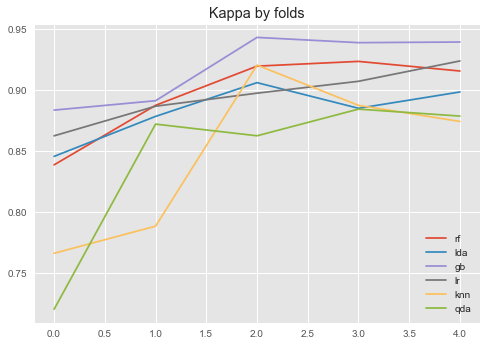

In [47]:
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)
    print("Mean Kappa score for {} is : {}".format(name, np.mean(scores)))
plt.legend(loc=0)
plt.title('Kappa by folds');

Загрузка из файла

df_data = pd.read_csv('../output/support_half_toes_data.csv', index_col=0)

id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

pr = list(set(df_data.columns.tolist()) - set(id_target_cols))

In [6]:
skf = StratifiedShuffleSplit(test_size=0.3, random_state=147, n_splits=1)
for train_index, test_index in skf.split(X=df_data[pr], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr], df_data.loc[test_index, pr]
    y_train, y_test = df_data.loc[train_index, 'support'], df_data.loc[test_index, 'support']

TRAIN: [ 9939 12539  5481 ...,   207 14690  7938] TEST: [ 6921 17002 23234 ..., 18633  2360 23462]


In [7]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

In [8]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [9]:
proba = model_pipe.predict_proba(X_test)

pred = model_pipe.predict(X_test)

In [10]:
accuracy_score(y_pred=pred, y_true=y_test)

0.96705374021064006

In [11]:
cohen_kappa_score(y1=y_test, y2=pred)

0.94905920446995706

In [12]:
print(classification_report(y_pred=pred, y_true=y_test))

             precision    recall  f1-score   support

         ds       0.97      0.96      0.96      3329
        lss       0.97      0.97      0.97      2047
        rss       0.96      0.97      0.97      2030

avg / total       0.97      0.97      0.97      7406



In [13]:
gb = model_pipe.steps[-1][1]

feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
feat_imp.columns = ['feat', 'imp']
feat_imp.sort_values('imp', ascending=False, inplace=True)

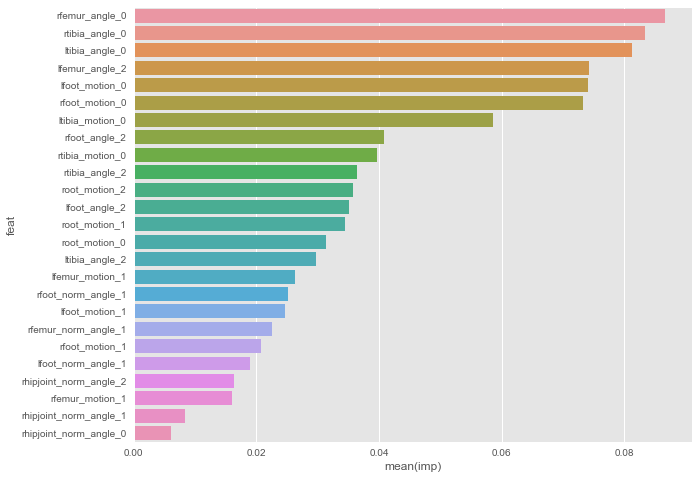

In [14]:
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, y='feat', x='imp', orient='h');

In [17]:
joblib.dump(filename='../output/half.pkl', value=model_pipe)

['../output/half.pkl']

После отбора некоррелированных фичей в наборе не осталось фичей по toes

Посмотрим,с какими фичами коррелируют фичи по движению toes

In [126]:
data = pd.read_csv('../output/preprocessed_data.csv', index_col=0)

In [127]:
predictors = sorted(set(data.columns.tolist()) - set(id_target_cols))

In [128]:
toes_cols = [col for col in predictors if 'toes' in col]

In [129]:
df_cor = data[predictors].corr(method="spearman")

In [130]:
df_corr_unst = df_cor.unstack().reset_index()

In [131]:
df_toes = df_corr_unst[df_corr_unst['level_0'].isin(toes_cols)]
df_toes = df_toes[df_toes['level_0'] != df_toes['level_1']]
df_toes.sort_values(0)

,level_0,level_1,0
20180,ltoes_norm_angle_2,rhipjoint_angle_2,-0.831446
20087,ltoes_norm_angle_2,lhipjoint_angle_2,-0.831446
20192,ltoes_norm_angle_2,root_angle_2,-0.831446
20195,ltoes_norm_angle_2,root_motion_5,-0.831446
36248,rtoes_angle_1,rtibia_norm_angle_0,-0.813815
36885,rtoes_norm_angle_0,rtoes_angle_1,-0.810569
36255,rtoes_angle_1,rtoes_norm_angle_0,-0.810569
37283,rtoes_norm_angle_2,root_angle_2,-0.792890
37178,rtoes_norm_angle_2,lhipjoint_angle_2,-0.792890
37271,rtoes_norm_angle_2,rhipjoint_angle_2,-0.792890


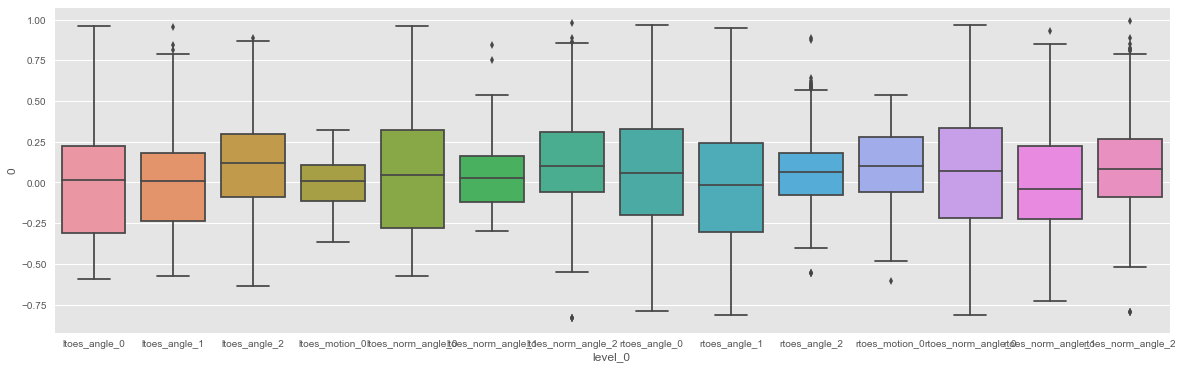

In [138]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=df_toes, x='level_0', y=0)
plt.title("Distribution of correlations");

In [146]:
feats_for_plot = df_toes[(df_toes[0] > 0.8) | (df_toes[0] < -0.8)]['level_0'].unique().tolist()

feats_for_plot.extend(df_toes[(df_toes[0] > 0.8) | (df_toes[0] < -0.8)]['level_1'].unique().tolist())

df_t_cor = df_toes[(df_toes['level_0'].isin(feats_for_plot)) | (df_toes['level_1'].isin(feats_for_plot))]

In [169]:
df_toes['abs'] = abs(df_toes[0])

df_agg = df_toes[~df_toes['level_1'].isin(toes_cols)].groupby('level_0').agg({'abs': 'idxmax'})

df_agg.columns = ['idxmax']

In [170]:
df_all = pd.merge(df_toes, df_agg, left_on='level_0', right_index=True).reset_index()

In [176]:
df_max = df_all[df_all['index'] == df_all['idxmax']].sort_values('abs', ascending=False)
df_max[['level_0', 'level_1', 0]]

,level_0,level_1,0
2854,rtoes_norm_angle_2,rfoot_norm_angle_2,0.988043
1291,ltoes_norm_angle_2,lfoot_norm_angle_2,0.980625
239,ltoes_angle_1,lfoot_angle_1,0.951540
870,ltoes_norm_angle_0,lfoot_norm_angle_0,0.951139
1802,rtoes_angle_1,rfoot_angle_1,0.950527
2433,rtoes_norm_angle_0,rfoot_norm_angle_0,0.926173
28,ltoes_angle_0,lfoot_angle_0,0.917712
1593,rtoes_angle_0,rfoot_norm_angle_0,0.905020
2014,rtoes_angle_2,rfoot_norm_angle_2,0.872209
451,ltoes_angle_2,lfoot_norm_angle_2,0.866092


## Предскажем support по данным с нижней половины тела исключая носки

Select predictors

In [48]:
id_target_cols = ['amc_path', 'frame', 'heel_strike_l', 'heel_strike_r', 'support', 'toe_off_l', 'toe_off_r']

In [49]:
lower_half_bones_minus_toes = ['root', 'femur', 'hipjoint', 'tibia', 'foot']

In [50]:
predictors = []
for col in data.columns.tolist():
    for bone in lower_half_bones_minus_toes:
        if bone in col:
            predictors.append(col)

In [51]:
predictors

['lfemur_motion_0',
 'lfemur_motion_1',
 'lfemur_motion_2',
 'lfoot_motion_0',
 'lfoot_motion_1',
 'ltibia_motion_0',
 'rfemur_motion_0',
 'rfemur_motion_1',
 'rfemur_motion_2',
 'rfoot_motion_0',
 'rfoot_motion_1',
 'root_motion_0',
 'root_motion_1',
 'root_motion_2',
 'root_motion_3',
 'root_motion_4',
 'root_motion_5',
 'rtibia_motion_0',
 'lfemur_angle_0',
 'lfemur_angle_1',
 'lfemur_angle_2',
 'lfemur_norm_angle_0',
 'lfemur_norm_angle_1',
 'lfemur_norm_angle_2',
 'lfoot_angle_0',
 'lfoot_angle_1',
 'lfoot_angle_2',
 'lfoot_norm_angle_0',
 'lfoot_norm_angle_1',
 'lfoot_norm_angle_2',
 'lhipjoint_angle_0',
 'lhipjoint_angle_1',
 'lhipjoint_angle_2',
 'lhipjoint_norm_angle_0',
 'lhipjoint_norm_angle_1',
 'lhipjoint_norm_angle_2',
 'ltibia_angle_0',
 'ltibia_angle_1',
 'ltibia_angle_2',
 'ltibia_norm_angle_0',
 'ltibia_norm_angle_1',
 'ltibia_norm_angle_2',
 'rfemur_angle_0',
 'rfemur_angle_1',
 'rfemur_angle_2',
 'rfemur_norm_angle_0',
 'rfemur_norm_angle_1',
 'rfemur_norm_angle_2',

In [52]:
len(predictors)

69

In [53]:
all_cols = copy.deepcopy(predictors)
all_cols.extend(id_target_cols)

In [54]:
data = data[all_cols]

Удалим коррелирующие признаки

Попробуем два критерия выбора

In [55]:
correm_mi = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='mutual_info_classif')

In [56]:
correm_mi.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [57]:
pr_mi = list(set(predictors) - set(correm_mi.all_corr_feats))

In [58]:
len(pr_mi)

25

In [59]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_mi = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_mi], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.6s finished


In [60]:
correm_f = CorrelatedRemoval(X=data[predictors], y=data['support'], method_xy='f_classif')

In [61]:
correm_f.evaluate()

Calculate features correlation ... 
Calculate correlation with target ... 
Sequentially exclude correlated variables ... 


In [62]:
pr_f = list(set(predictors) - set(correm_f.all_corr_feats))

In [63]:
len(pr_f)

24

In [64]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('model', LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147))  
])

kappa_score_f = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                scoring=make_scorer(cohen_kappa_score), 
                X=data[pr_f], y=data['support'])

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.4s finished


In [65]:
print("Mean Kappa for mutual_inf: {}".format(np.mean(kappa_score_mi)))
print("Std Kappa for mutual_inf: {}".format(np.std(kappa_score_mi)))

print("Mean Kappa for f_classif: {}".format(np.mean(kappa_score_f)))
print("Std Kappa for f_classif: {}".format(np.std(kappa_score_f)))

Mean Kappa for mutual_inf: 0.8920824861914246
Std Kappa for mutual_inf: 0.01855838277260776
Mean Kappa for f_classif: 0.8783307584497365
Std Kappa for f_classif: 0.021686655270855223


Будем использовать критерий mutual information

In [66]:
final_all_cols = copy.deepcopy(id_target_cols)
final_all_cols.extend(pr_mi)

df_data = data[final_all_cols]

df_data.to_csv('../output/support_half_toes_data.csv')

In [69]:
scores_dict = {}

In [70]:
models = {
    'lr': LogisticRegression(penalty='l1', C=0.1, class_weight="balanced", random_state=147),
    'rf': RandomForestClassifier(class_weight="balanced", max_depth=6, n_estimators=500, random_state=147),
    'lda': LinearDiscriminantAnalysis(),
    'qda': QuadraticDiscriminantAnalysis(),
    'knn': KNeighborsClassifier(n_neighbors=10),
    'gb': GradientBoostingClassifier(n_estimators=100, max_depth=5)
}

for name, model in tqdm.tqdm_notebook(models.items()):
    model_pipe = Pipeline([
        ('std_sc', StandardScaler()),
        ('model', model)  
    ])

    sc = cross_val_score(cv=5, estimator=model_pipe, verbose=True, 
                    scoring=make_scorer(cohen_kappa_score), 
                    X=df_data[pr_mi].values, y=df_data['support'].values)
    scores_dict[name] = sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

C:\Users\Kseniya\Anaconda2\envs\py34\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.7s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [71]:
scores_dict

{'gb': array([ 0.8795084 ,  0.88083238,  0.9438238 ,  0.93792378,  0.93940915]),
 'knn': array([ 0.76505777,  0.79635424,  0.91650275,  0.89437583,  0.88196733]),
 'lda': array([ 0.82901483,  0.88007215,  0.90133887,  0.88166129,  0.90825291]),
 'lr': array([ 0.87014565,  0.87049137,  0.90323978,  0.90032265,  0.91621299]),
 'qda': array([ 0.73653993,  0.87963838,  0.86426231,  0.87049963,  0.88508242]),
 'rf': array([ 0.84326942,  0.88835289,  0.91822021,  0.91925483,  0.91757789])}

Mean Kappa score for rf is : 0.897335046579593
Mean Kappa score for lda is : 0.8800680102330654
Mean Kappa score for gb is : 0.9162995024416878
Mean Kappa score for lr is : 0.8920824861914246
Mean Kappa score for knn is : 0.8508515842700245
Mean Kappa score for qda is : 0.8472045342616159


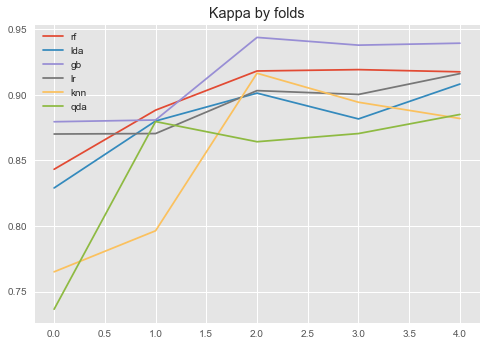

In [72]:
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)
    print("Mean Kappa score for {} is : {}".format(name, np.mean(scores)))
plt.legend(loc=0)
plt.title('Kappa by folds');

In [74]:
skf = StratifiedShuffleSplit(test_size=0.3, random_state=147, n_splits=1)
for train_index, test_index in skf.split(X=df_data[pr_mi], y=df_data['support'].values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_data.loc[train_index, pr_mi], df_data.loc[test_index, pr_mi]
    y_train, y_test = df_data.loc[train_index, 'support'], df_data.loc[test_index, 'support']

TRAIN: [ 9939 12539  5481 ...,   207 14690  7938] TEST: [ 6921 17002 23234 ..., 18633  2360 23462]


In [75]:
model_pipe = Pipeline([
    ('std_sc', StandardScaler()),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))  
])

In [76]:
model_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [77]:
proba = model_pipe.predict_proba(X_test)

pred = model_pipe.predict(X_test)

In [78]:
accuracy_score(y_pred=pred, y_true=y_test)

0.9671887658655145

In [79]:
cohen_kappa_score(y1=y_test, y2=pred)

0.94926614473409643

In [80]:
print(classification_report(y_pred=pred, y_true=y_test))

             precision    recall  f1-score   support

         ds       0.97      0.96      0.96      3329
        lss       0.97      0.97      0.97      2047
        rss       0.96      0.97      0.97      2030

avg / total       0.97      0.97      0.97      7406



In [83]:
gb = model_pipe.steps[-1][1]

feat_imp = pd.DataFrame([X_train.columns.tolist(), gb.feature_importances_.tolist()]).T
feat_imp.columns = ['feat', 'imp']
feat_imp.sort_values('imp', ascending=False, inplace=True)

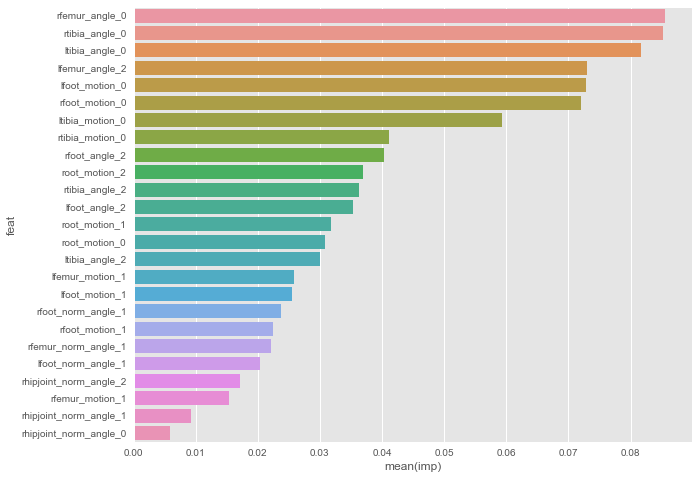

In [107]:
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp, y='feat', x='imp', orient='h');

In [106]:
joblib.dump(filename='../output/half_toes.pkl', value=model_pipe)

['../output/half_toes.pkl']